In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import datasets, models, layers, optimizers
#Please read comments for work explanation

In [57]:
from tensorflow.keras.models import Sequential          # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D              # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D        # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten             # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout      # Dropout: Applies Dropout to the input. Dense: Just your regular densely-connected NN layer.
from tensorflow.keras.layers import Activation                                                    #

### Load Data Set, Shape, Visualize

In [58]:
#Load numpy image data set. This data set does not include label.
X = np.load('images.npy')
y = pd.read_csv('Labels.csv')

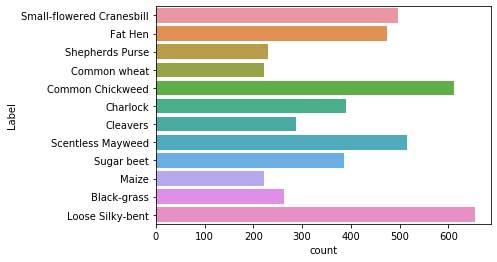

In [59]:
#Check distribution of labels. Loose Silky-bent with most data. Second highest is Common Chickweed
ax = sns.countplot(y="Label", data=y)

In [60]:
le = LabelEncoder() 
y['Label_Encoded']=le.fit_transform(y['Label'])
#Create new column for Label Encoded 'Label'

In [61]:
#Verify what Label is encoded to what label number.
y_verify = y.drop_duplicates().sort_values(by='Label_Encoded').reset_index(drop='True')

#Using Encoded y_verify table, create dictionary that labels index to 'label'
dict_label ={}
for i in range(y_verify['Label'].count()):
    dict_kv = {y_verify.iloc[i][1]: str(y_verify.iloc[i][0])}
    dict_label.update(dict_kv)
print(dict_label)


{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


In [62]:
#Need to drop 'Label' from y data and convert to numpy array
y.drop('Label',axis=1,inplace=True)

In [63]:
#Convert 'Label_Encoded' to numpy array
y = y.to_numpy()

In [64]:
print(X.shape) #Check image data set size
print(y.shape) #Check Label data set

#Number of rows are same for X and y dataset

(4750, 128, 128, 3)
(4750, 1)


 Label 
 Label Id: 8 
 Name: Scentless Mayweed


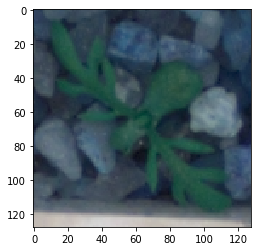

In [65]:
#Pull images of X data given index for visual checks
index = 3000
image = X[index]
label = y[index][0]
print(' Label \n Label Id: {} \n Name: {}'.format(label, dict_label[label]))
plt.imshow(image)

#Images are all colored 128 by 128. It is color because third dimension is 3.

### Normalize, Gaussian Blurring, Visualize Data after pre-processing

In [66]:
##Normalize X data set
X = X.astype('float32')
X/=255

In [77]:
##Gaussian Blurring all 4750 images
X_blur = []
for gf in range(X.shape[0]):
    Gaussian = cv2.GaussianBlur(X[gf], (5, 5), 0)
    rgb = cv2.cvtColor(Gaussian,cv2.COLOR_BGR2RGB)
    X_blur.append(rgb)
    
X_blur = np.array(X_blur)

In [78]:
#Verify new shape is same as old X shape
X_blur.shape

(4750, 128, 128, 3)

 Label 
 Label Id: 8 
 Name: Scentless Mayweed


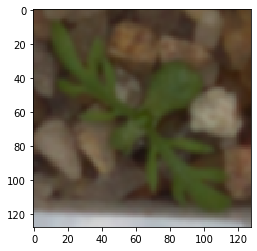

In [79]:
##Visual Blurred Data
#Pull images of X_blurr data given index for visual checks
index = 3000
image = X_blur[index]
label = y[index][0]
print(' Label \n Label Id: {} \n Name: {}'.format(label, dict_label[label]))
plt.imshow(image)

#With Gaussian and Color filter, green color is more exposed than background

### Convert labels to one-hot-vectors.

In [80]:
## Convert labels to one hot vectors.
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_hot_vector = enc.fit_transform(y)

In [81]:
#There are twelve columns because there are total of twelve labels
y_hot_vector.shape

(4750, 12)

###  Split the dataset into training, testing, and validation set

In [82]:
from sklearn.model_selection import train_test_split
# Split the data up in train and test sets with 0.3 split test
X_train, X_test, y_train, y_test = train_test_split(X_blur, y_hot_vector, test_size=0.30, random_state=7)

#Further split test data in 50% to grab validation data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=7)

### Print the label for y_train[0]

In [83]:
#Dictionary place holder
print(dict_label)

#Label for y_train[0]
label = y_train[0]
print('Label Id: {}'.format(label))
#000100000000 means it is index 3 = 'Cleavers'

{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}
Label Id: [0 0 0 1 0 0 0 0 0 0 0 0]


### Check the shape of data, Reshape data into shapes compatible with Keras models if it’s not already. If it’s already in the compatible shape, then comment in the notebook that it’s already in compatible shape. 

In [148]:
#Check Train, Validation, Test shape
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

#Training, Validation, Test split out correctly

(3325, 128, 128, 3) (3325, 12)
(712, 128, 128, 3) (712, 12)
(713, 128, 128, 3) (713, 12)


### Define layers 

In [189]:
#Open Sequential
model = Sequential()
#this Conv2D layer learning 20 convolution filters that are 5 by 5
model.add(Conv2D(20,(5,5),padding='same', input_shape = (128,128,3)))
#Then ReLU is passed along with 2x2 max pooling horizontally and vertically
#Activation takes max operation over each area and takes give steps both X and Y axis
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#use same method but this time use 40 convolutional filters
model.add(Conv2D(20,(5,5),padding='same', input_shape = (128,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Now flat volume to set of fully connected layers. Flatten to single vector of previous MaxPooling layer
model.add(Flatten())
#Now Dense layer can be added. Choosing 400.
model.add(Dense(350))
#Now put activation function as 'ReLU'
#- Keeping relu because gradient computation is very simple (either 0 or 1 depending on the sign of x). 
#Also, the computational step of a ReLU is easy that any negative elements are set to 0.0 and no exponentials, no multiplication or division operations. 
#Therefore, this function was used in the beginning of the training to first hidden node with improving non-linearity.
model.add(Activation('relu'))
#Then use softmax classifier
model.add(Dense(12, activation="softmax"))

model.summary()
#Total Param ~ 7 million

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 128, 128, 20)      1520      
_________________________________________________________________
activation_27 (Activation)   (None, 128, 128, 20)      0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 64, 20)        10020     
_________________________________________________________________
activation_28 (Activation)   (None, 64, 64, 20)        0         
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 32, 32, 20)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 20480)           

### Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

In [191]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [192]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Fit and evaluate model and print confusion matrix

In [187]:
#Script borrowed from mentor
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [193]:
#Script borrowed from mentor
bs = 50
epoch = 10
history = model.fit(X_train,
                    y_train,
                    batch_size=bs,
                    epochs=epoch,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

#I don't have more local disk memory to run more

Train on 3325 samples, validate on 712 samples
Epoch 1/10


3300/3325 [============================>.] - ETA: 0s - loss: 2.2071 - accuracy: 0.2555
Epoch 00001: val_loss improved from inf to 1.79692, saving model to cifar_cnn_checkpoint_01_loss1.7969.h5
3325/3325 [==============================] - 39s 12ms/sample - loss: 2.2009 - accuracy: 0.2574 - val_loss: 1.7969 - val_accuracy: 0.3947
Epoch 2/10
3300/3325 [============================>.] - ETA: 0s - loss: 1.4092 - accuracy: 0.5221
Epoch 00002: val_loss improved from 1.79692 to 1.33618, saving model to cifar_cnn_checkpoint_02_loss1.3362.h5
3325/3325 [==============================] - 41s 12ms/sample - loss: 1.4074 - accuracy: 0.5224 - val_loss: 1.3362 - val_accuracy: 0.5281
Epoch 3/10
3300/3325 [============================>.] - ETA: 0s - loss: 1.0744 - accuracy: 0.6309
Epoch 00003: val_loss improved from 1.33618 to 1.11680, saving model to cifar_cnn_checkpoint_03_loss1.1168.h5
3325/3325 [==============================] - 42s 13ms/sample - loss: 1.0767 - accuracy: 0.6304 - val_loss: 1.1168 - v

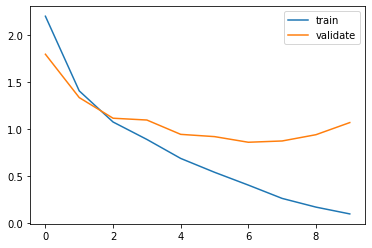

In [195]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()
#Training data starts overfitting while validation stops improving

In [196]:
# Score trained model.
scores = model.evaluate(X_test, y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
#Test loss = 1.2
#Test accuracy = 0.711


713/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss: 1.2044042587949049
Test accuracy: 0.71107996


Confusion Matrix Below

In [213]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
species = ['Black-grass','Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen'
           ,'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse','Small-flowered Cranesbill'
           , 'Sugar beet']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\lee.jhsy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-238-11462965b211>", line 8, in <module>
    plot_confusion_matrix(confusion_mtx, classes = species)
  File "<ipython-input-213-ce69bacac3dc>", line 19, in plot_confusion_matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
NameError: name 'itertools' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\lee.jhsy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\lee.jhsy\anaconda3\lib\site

NameError: name 'itertools' is not defined

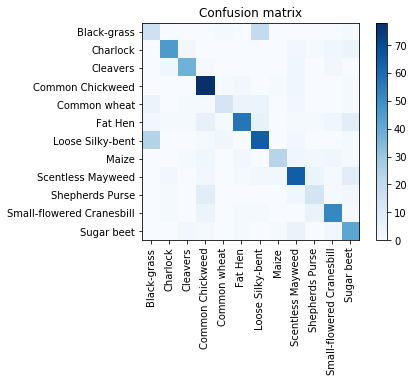

In [238]:
y_pred = model.predict(X_test)

#Return the column position where the max value is
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)

confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes = species)

Common Chickweed and Scentless Mayweed were highly detected

Overall, diagnal shows that classification was effective compare to misclassifications

### Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

In [253]:
#X_test[2]'s result is y_pred[2]
#X_test[3]'s result is y_pred[3]
#X_test[33]'s result is y_pred[36]
#X_test[59]'s result is y_pred[59]

#Need to compare between y_pred vs y_test
print('Predicted:',y_pred[2],'||| Actual:',y_test[2])
print('Predicted:',y_pred[3],'||| Actual:',y_test[3])
print('Predicted:',y_pred[33],'||| Actual:',y_test[33])
print('Predicted:',y_pred[36],'||| Actual:',y_test[36])
print('Predicted:',y_pred[59],'||| Actual:',y_test[59])

#Out of 5 inputs: X_test[2],X_test[3]X_test[59] were correctly classified

print('\n\nPlease refer to below dictionary for labels:\n',dict_label)

Predicted: 3 ||| Actual: 3
Predicted: 2 ||| Actual: 2
Predicted: 8 ||| Actual: 9
Predicted: 3 ||| Actual: 5
Predicted: 5 ||| Actual: 5


Please refer to below dictionary for labels:
 {0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}
